##Time Series Prediction and Forecasting for a Heart Rate

To be able to predict the next results after a 4 hours via Medical sensors, we need to import Python libraries

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import statsmodels.api as sm
import itertools
import sklearn
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from dateutil.parser import parse
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Loading collected heart rate dataset

In [ ]:
# load the data set
# As the parameter, the file path should be provided. Additionally, GitHub URL can also be provided as follows.
Heart_record = pd.read_csv('/content/drive/MyDrive/AppliedAI/Assessment 1/PT_Train.csv')


##Heart-rate Data Wrangling

In [ ]:
#View the first 5 rows of the dataset Heart_record
Heart_record.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
#The last 5 row of the dataset Heart_record
Heart_record.tail()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN
225,17/08/2015 18:54,138,54,NaN,NaN


In [ ]:
#Verify the amount of rows and columns in dataset
Heart_record.shape

(226, 5)

In [ ]:
#To get some basic information about the dataset Heart_record
Heart_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp (GMT)             226 non-null    object 
 1   Lifetouch Heart Rate        226 non-null    int64  
 2   Lifetouch Respiration Rate  226 non-null    int64  
 3   Oximeter SpO2               191 non-null    float64
 4   Oximeter Pulse              191 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.0+ KB


In [ ]:
#Checking if there is any null value within the dataset
Heart_record.isnull()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,False,False,False,True,True
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
221,False,False,False,True,True
222,False,False,False,True,True
223,False,False,False,True,True
224,False,False,False,True,True


In [ ]:
#Checking for duplicated values
Heart_record.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
221    False
222    False
223    False
224    False
225    False
Length: 226, dtype: bool

No duplicate values from above 

In [ ]:
#Viewing the null value in the rows althogether in total
Heart_record.isna().sum()

Timestamp (GMT)                0
Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

In [ ]:
#Checking the type of the dataset columns 
Heart_record.dtypes

Timestamp (GMT)                object
Lifetouch Heart Rate            int64
Lifetouch Respiration Rate      int64
Oximeter SpO2                 float64
Oximeter Pulse                float64
dtype: object

In [ ]:
#Verifying the unique number of each columns
Heart_record.nunique()

Timestamp (GMT)               226
Lifetouch Heart Rate           43
Lifetouch Respiration Rate     32
Oximeter SpO2                  10
Oximeter Pulse                 35
dtype: int64

Heart-rate Data Pre-processing

From the check above, there are null values, we will therefore go ahead to pre-process it

In [ ]:
#Converting Timestamp (GMT) to a datetime format
Heart_record['Timestamp (GMT)']=pd.to_datetime(Heart_record['Timestamp (GMT)'])
Heart_record.set_index('Timestamp (GMT)', inplace=True)
Heart_record

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
#Dropping the rows with null values
Heart_record = Heart_record.dropna()
Heart_record

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
2015-08-17 15:14:00,132,41,92.0,134.0
...,...,...,...,...
2015-08-17 18:41:00,152,55,98.0,152.0
2015-08-17 18:42:00,152,54,97.0,142.0
2015-08-17 18:43:00,150,54,98.0,151.0


In [ ]:
#Decribing dataset columns showing some statistical data
Heart_record.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,191.000000,191.000000,191.000000,191.000000
mean,2711.628272,2616.052356,83.450262,126.335079
std,12311.688863,12331.721986,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,140.000000,44.000000,93.000000,139.000000
75%,155.000000,52.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


Record time from 15:09 to 18:47 on 17/08/2015

In [ ]:
#Lifetouch Column array
Heart_record['Lifetouch Heart Rate'].unique()

array([  144,   140,   138,   133,   132,   136,   137,   139,   141,
         120,   135,   129, 61441, 61442,   142,   106,   143,   149,
         154,   152,   150,   148,   134,   146,   131,   151,   161,
         158,   160,   155,   153,   163,   162,   159,   166,   167,
         157,   164,   169,   170,   156])

##Feature Extraction

In [ ]:
#Dropping unwanted columns
Heart_record = Heart_record.drop(columns=['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'])
Heart_record

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
2015-08-17 15:14:00,132
...,...
2015-08-17 18:41:00,152
2015-08-17 18:42:00,152
2015-08-17 18:43:00,150


In [ ]:
#There is no need to sort the value since we will be working to the timestamp
Heart_record.sort_values(by=['Lifetouch Heart Rate'],ascending=True )

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:49:00,106
2015-08-17 15:32:00,120
2015-08-17 15:38:00,129
2015-08-17 17:08:00,131
2015-08-17 16:37:00,132
...,...
2015-08-17 15:43:00,61441
2015-08-17 15:44:00,61441
2015-08-17 15:40:00,61442


##Exploratory Data Analysis (EDA)

I made some data visualisation to help us understand the relationship of the cleaned dataset

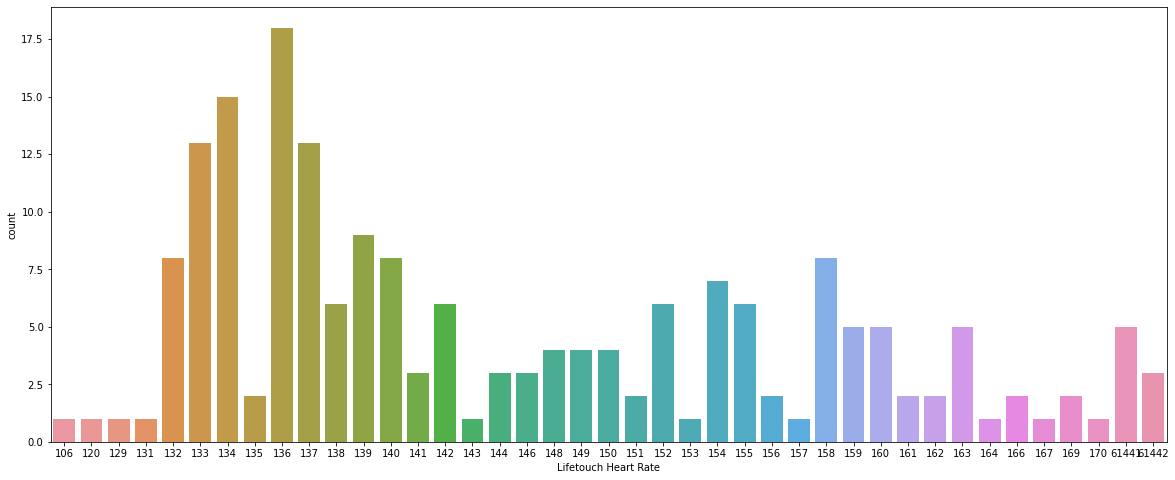

In [ ]:
# Summarise heart rate details in countplot
plt.figure(figsize=(20, 8))
sns.countplot(x=Heart_record['Lifetouch Heart Rate'])

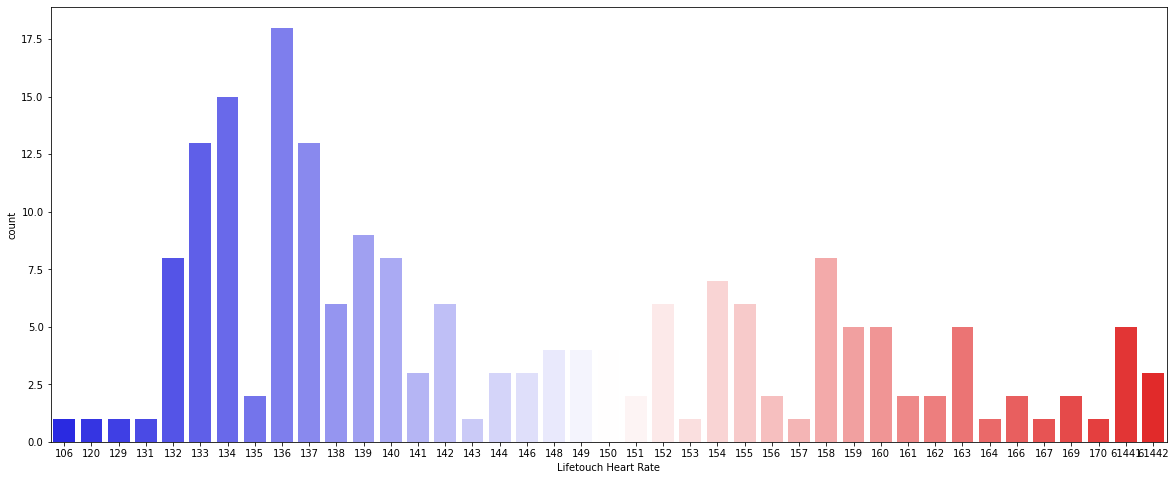

In [ ]:
from seaborn.widgets import color_palette
plt.figure(figsize=(20, 8))
sns.countplot(x="Lifetouch Heart Rate", data=Heart_record, palette='bwr')
plt.show()

In [ ]:
# # convert Timestamp to int
# Heart_record['Minutes'] = list(range(0, len(Heart_record.index)))

# Heart_record.head()

In [ ]:
#Creating a mean value for the dataset
Heart_record.drop(Heart_record[Heart_record['Lifetouch Heart Rate']>200].index, inplace=True)
mean = Heart_record['Lifetouch Heart Rate'].mean()
Heart_record['Lifetouch Heart Rate'] = np.where (Heart_record['Lifetouch Heart Rate'] > 200, mean, Heart_record['Lifetouch Heart Rate'])

In [ ]:
#Reviewing the new dataset
Heart_record.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2015-08-17 15:10:00 to 2015-08-17 18:46:00
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lifetouch Heart Rate  183 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [ ]:
#Viewing the last 5 rows of the dataset
Heart_record.tail()

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 18:41:00,152.0
2015-08-17 18:42:00,152.0
2015-08-17 18:43:00,150.0
2015-08-17 18:45:00,158.0
2015-08-17 18:46:00,158.0


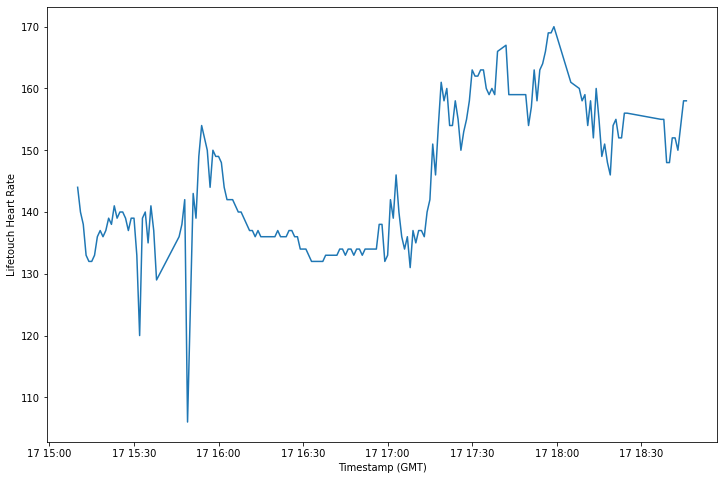

In [ ]:
# plot time series
#Because it has been set to an index, the word Timestamp (GMT) would not be uses, instead Heart_record.index
plt.figure(figsize=(12, 8))
plt.plot(Heart_record.index,Heart_record['Lifetouch Heart Rate'])
plt.xlabel('Timestamp (GMT)')
plt.ylabel('Lifetouch Heart Rate')
plt.show()

In [ ]:
Heart_record

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:10:00,144.0
2015-08-17 15:11:00,140.0
2015-08-17 15:12:00,138.0
2015-08-17 15:13:00,133.0
2015-08-17 15:14:00,132.0
...,...
2015-08-17 18:41:00,152.0
2015-08-17 18:42:00,152.0
2015-08-17 18:43:00,150.0


The above plot image shows that there is no stationarity; varying means and variance. Since Lorenz method of analogues (LMA) can be applied on non-stationary data, we will go ahead with the model implementation

##STATIONARITY PROCEDURE

In [ ]:
# convert Timestamp to int
Heart_record['Minutes'] = list(range(0, len(Heart_record.index)))

Heart_record.head()

,Lifetouch Heart Rate,Minutes
Timestamp (GMT),,
2015-08-17 15:10:00,144.0,0
2015-08-17 15:11:00,140.0,1
2015-08-17 15:12:00,138.0,2
2015-08-17 15:13:00,133.0,3
2015-08-17 15:14:00,132.0,4


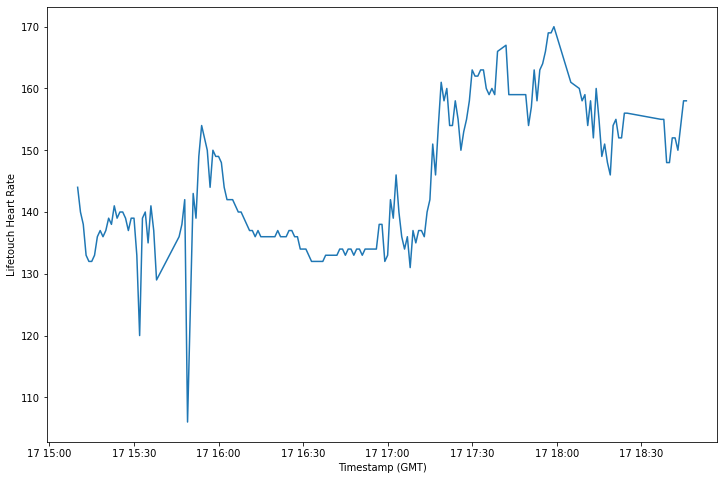

In [ ]:
# plot time series
#Because it has been set to an index, the word Timestamp (GMT) would not be uses, instead df5x.index
plt.figure(figsize=(12, 8))
plt.plot(Heart_record.index,Heart_record['Lifetouch Heart Rate'])
plt.xlabel('Timestamp (GMT)')
plt.ylabel('Lifetouch Heart Rate')
plt.show()

Using KPSS test

In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value} ')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(Heart_record['Lifetouch Heart Rate'])

p value: 0.01 
Result: The series is not stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Log-transformation

In [ ]:
# add new column 'Log-Sales' with log transformed values
Heart_record['Log-Lifetouch'] = np.log(Heart_record['Lifetouch Heart Rate']) 

print(Heart_record.shape)
Heart_record.head(15)

(183, 3)


,Lifetouch Heart Rate,Minutes,Log-Lifetouch
Timestamp (GMT),,,
2015-08-17 15:10:00,144.0,0,4.969813
2015-08-17 15:11:00,140.0,1,4.941642
2015-08-17 15:12:00,138.0,2,4.927254
2015-08-17 15:13:00,133.0,3,4.890349
2015-08-17 15:14:00,132.0,4,4.882802
2015-08-17 15:15:00,132.0,5,4.882802
2015-08-17 15:16:00,133.0,6,4.890349
2015-08-17 15:17:00,136.0,7,4.912655
2015-08-17 15:18:00,137.0,8,4.919981


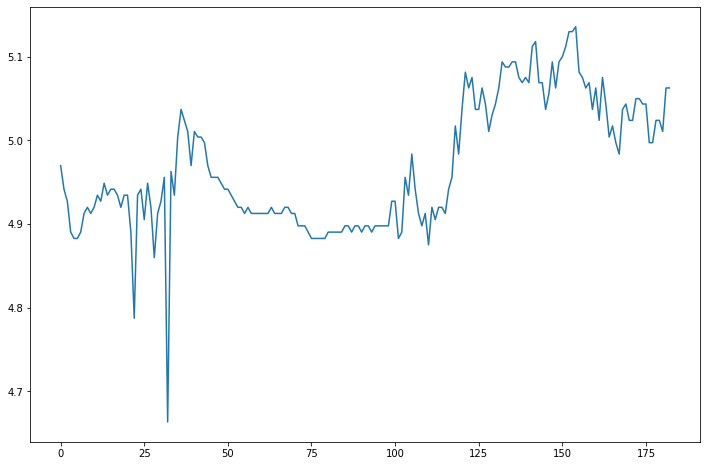

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(Heart_record['Minutes'],Heart_record['Log-Lifetouch'])
plt.xticks(np.arange(min(Heart_record['Minutes']), max(Heart_record['Minutes'])+1, 25))  # define x-axis step size
plt.show()

In [ ]:
check_stationarity(Heart_record['Lifetouch Heart Rate'])

p value: 0.01 
Result: The series is not stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
Heart_record['Deseasonalised-Lifetouch'] = Heart_record[['Log-Lifetouch']].diff(axis=0, periods=12)
Heart_record.head(15)

,Lifetouch Heart Rate,Minutes,Log-Lifetouch,Deseasonalised-Lifetouch
Timestamp (GMT),,,,
2015-08-17 15:10:00,144.0,0,4.969813,NaN
2015-08-17 15:11:00,140.0,1,4.941642,NaN
2015-08-17 15:12:00,138.0,2,4.927254,NaN
2015-08-17 15:13:00,133.0,3,4.890349,NaN
2015-08-17 15:14:00,132.0,4,4.882802,NaN
2015-08-17 15:15:00,132.0,5,4.882802,NaN
2015-08-17 15:16:00,133.0,6,4.890349,NaN
2015-08-17 15:17:00,136.0,7,4.912655,NaN
2015-08-17 15:18:00,137.0,8,4.919981,NaN


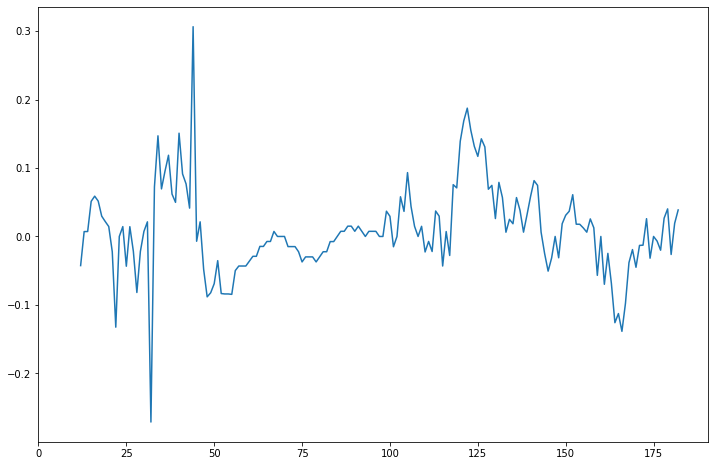

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(Heart_record['Minutes'],Heart_record['Deseasonalised-Lifetouch'])
plt.xticks(np.arange(min(Heart_record['Minutes']), max(Heart_record['Minutes'])+1, 25))  # define x-axis step size
plt.show()

In [ ]:
check_stationarity(Heart_record['Deseasonalised-Lifetouch'][12:])

p value: 0.1 
Result: The series is stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [ ]:
Heart_record['Differenced-Lifetouch'] = Heart_record[['Deseasonalised-Lifetouch']].diff(axis=0, periods=1)
Heart_record.head(20)

,Lifetouch Heart Rate,Minutes,Log-Lifetouch,Deseasonalised-Lifetouch,Differenced-Lifetouch
Timestamp (GMT),,,,,
2015-08-17 15:10:00,144.0,0,4.969813,NaN,NaN
2015-08-17 15:11:00,140.0,1,4.941642,NaN,NaN
2015-08-17 15:12:00,138.0,2,4.927254,NaN,NaN
2015-08-17 15:13:00,133.0,3,4.890349,NaN,NaN
2015-08-17 15:14:00,132.0,4,4.882802,NaN,NaN
2015-08-17 15:15:00,132.0,5,4.882802,NaN,NaN
2015-08-17 15:16:00,133.0,6,4.890349,NaN,NaN
2015-08-17 15:17:00,136.0,7,4.912655,NaN,NaN
2015-08-17 15:18:00,137.0,8,4.919981,NaN,NaN


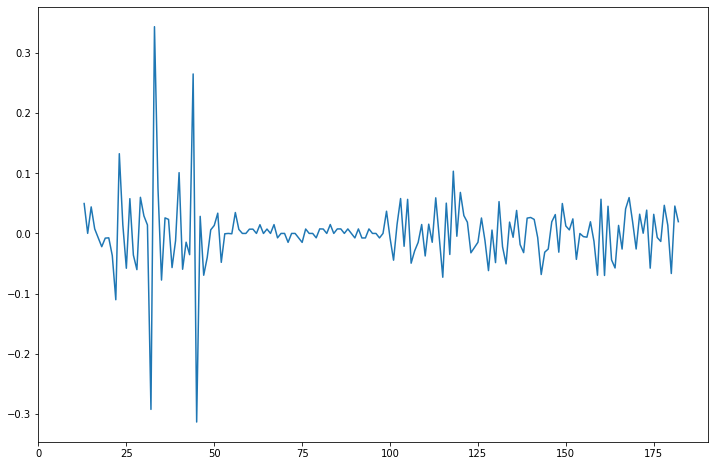

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(Heart_record['Minutes'],Heart_record['Differenced-Lifetouch'])
plt.xticks(np.arange(min(Heart_record['Minutes']), max(Heart_record['Minutes'])+1, 25))  # define x-axis step size
plt.show()

In [ ]:
check_stationarity(Heart_record['Differenced-Lifetouch'][13:])

p value: 0.1 
Result: The series is stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


##MODEL 1 - Lorenz Method of Analogues (LMA)

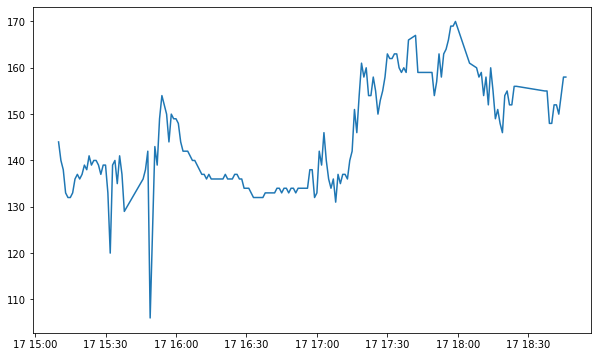

In [ ]:
#Viewing the non-stationary data plot
plt.figure(figsize=(10, 6))
plt.plot(Heart_record.index, Heart_record['Lifetouch Heart Rate'])

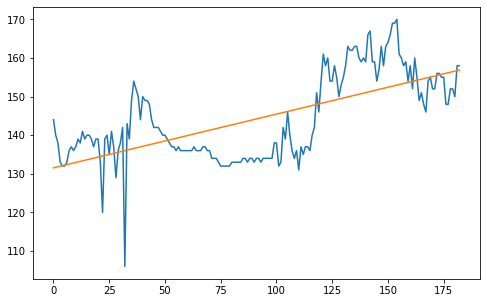

In [ ]:
# Plotting a line chart
plt.figure(figsize=(8, 5))
plt.plot(Heart_record['Minutes'], Heart_record['Lifetouch Heart Rate']) 

# fit a linear regression (trend)
m, b = np.polyfit(Heart_record['Minutes'], Heart_record['Lifetouch Heart Rate'], 1)
plt.plot(Heart_record['Minutes'], m * Heart_record['Minutes'] + b)

#Embedding application

In [ ]:
# get values in column 'Lifetouch Hear Rate' as a numpy array
x = Heart_record['Lifetouch Heart Rate'].to_numpy()

# get delay embedding series
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print(X.shape)

(181, 3)


In [ ]:
# get delay embedding series
print("\nStacked data with delay embedding 2:")
X_2 = np.vstack((x[:-1], x[1:])).T
print(X_2[:5,:])

print("\nStacked data with delay embedding 3:")
X_3 = np.vstack((x[:-2], x[1:-1], x[2:])).T
print(X_3[:5,:])


Stacked data with delay embedding 2:
[[144. 140.]
 [140. 138.]
 [138. 133.]
 [133. 132.]
 [132. 132.]]

Stacked data with delay embedding 3:
[[144. 140. 138.]
 [140. 138. 133.]
 [138. 133. 132.]
 [133. 132. 132.]
 [132. 132. 133.]]


In [ ]:
# get 126 entries from past record which is 70% of the entire dataset 181
past_record = X_3[:126,:]
print("Stacked data with delay embedding 3:")
print(past_record[-5:,:])

Stacked data with delay embedding 3:
[[161. 158. 160.]
 [158. 160. 154.]
 [160. 154. 154.]
 [154. 154. 158.]
 [154. 158. 155.]]


In [ ]:
# get 55 entries from past record which is 30% of the entire dataset 181
post_record = X_3[126:]
print("Stacked data with delay embedding 3:")
print(post_record[-5:,:])

Stacked data with delay embedding 3:
[[148. 148. 152.]
 [148. 152. 152.]
 [152. 152. 150.]
 [152. 150. 158.]
 [150. 158. 158.]]


In [ ]:
# get latest data
latest = np.reshape(post_record[-1,:],(-1,3))
print(f"\n Latest observation:{latest}")


 Latest observation:[[150. 158. 158.]]


In [ ]:
3# find data like most recent observation (latest)
rec = cdist(post_record[:-1], latest)
record = np.argsort(rec, axis=0)  # return indices of sorted values

print("Ten nearest neighbors from past record:")
print(post_record[record[:10,0],:])

Ten nearest neighbors from past record:
[[152. 156. 156.]
 [152. 160. 155.]
 [153. 155. 158.]
 [150. 153. 155.]
 [146. 154. 155.]
 [154. 157. 163.]
 [152. 152. 156.]
 [156. 156. 155.]
 [155. 158. 163.]
 [154. 158. 152.]]


In [ ]:
# standard prediction:
pred = x[record[0,0]+3]
print(f"Standard prediction: {pred}")

# average prediction:
neighbours = 2
pred2 = (1/neighbours)*sum(x[record[:neighbours,0]+3])
print(f"\nAveraged prediction: {pred2}")

Standard prediction: 141.0

Averaged prediction: 145.5


However, LMA does not seem to work for multple data point forecast but it is giving an idea of the range of value mean to expect.

##Model 2- MOVING AVERAGE 

Moving Average is good for Stationarity data, but because it is more than 3 predictions(20 predictions),we will not use it

In [ ]:
from pandas import read_csv
from numpy import mean
Heart_record_MA = read_csv('/content/drive/MyDrive/AppliedAI/Assessment 1/PT_Train.csv') #, header=0, index_col=0)


In [ ]:
Heart_record_MA.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
#Dropping the rows with null values
Heart_record_MA = Heart_record_MA.dropna()
Heart_record_MA

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0
5,17/08/2015 15:14,132,41,92.0,134.0
...,...,...,...,...,...
212,17/08/2015 18:41,152,55,98.0,152.0
213,17/08/2015 18:42,152,54,97.0,142.0
214,17/08/2015 18:43,150,54,98.0,151.0
216,17/08/2015 18:45,158,53,95.0,31.0


In [ ]:
# impute missing values
# dataframe.bfill() is used to backward fill the missing values in the dataset.
Heart_record_MA = Heart_record_MA.fillna(Heart_record_MA.bfill())
Heart_record_MA.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0
5,17/08/2015 15:14,132,41,92.0,134.0


In [ ]:
#Dropping unwanted columns
Heart_record_MA = Heart_record_MA.drop(columns=['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'])
Heart_record_MA

,Timestamp (GMT),Lifetouch Heart Rate
1,17/08/2015 15:10,144
2,17/08/2015 15:11,140
3,17/08/2015 15:12,138
4,17/08/2015 15:13,133
5,17/08/2015 15:14,132
...,...,...
212,17/08/2015 18:41,152
213,17/08/2015 18:42,152
214,17/08/2015 18:43,150
216,17/08/2015 18:45,158


In [ ]:
#Converting Timestamp (GMT) to a datetime format
Heart_record_MA['Timestamp (GMT)'] = pd.to_datetime(Heart_record_MA['Timestamp (GMT)'])
Heart_record_MA.set_index('Timestamp (GMT)', inplace=True)
Heart_record_MA

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
2015-08-17 15:14:00,132
...,...
2015-08-17 18:41:00,152
2015-08-17 18:42:00,152
2015-08-17 18:43:00,150


In [ ]:
# prepare situation
X = Heart_record_MA.values
window = 3
record = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

In [ ]:
# walk forward over time steps in test
for t in range(len(test)):
  length = len(record)
  ypred = mean([record[i] for i in range(length-window,length)])
  ytest = test[t]
  predictions.append(ypred)
  record.append(ytest)
  print('predicted=%f, expected=%f' % (ypred, ytest))

predicted=140.666667, expected=133.000000
predicted=137.000000, expected=132.000000
predicted=134.333333, expected=132.000000
predicted=132.333333, expected=133.000000
predicted=132.333333, expected=136.000000
predicted=133.666667, expected=137.000000
predicted=135.333333, expected=136.000000
predicted=136.333333, expected=137.000000
predicted=136.666667, expected=139.000000
predicted=137.333333, expected=138.000000
predicted=138.000000, expected=141.000000
predicted=139.333333, expected=139.000000
predicted=139.333333, expected=140.000000
predicted=140.000000, expected=140.000000
predicted=139.666667, expected=139.000000
predicted=139.666667, expected=137.000000
predicted=138.666667, expected=139.000000
predicted=138.333333, expected=139.000000
predicted=138.333333, expected=133.000000
predicted=137.000000, expected=120.000000
predicted=130.666667, expected=139.000000
predicted=130.666667, expected=140.000000
predicted=133.000000, expected=135.000000
predicted=138.000000, expected=141

##MODEL 3 - SARIMAX

We can use SARIMAX model for predicting the dataset as it is fit for purpose

In [ ]:
# load the data set
Heart = pd.read_csv('/content/drive/MyDrive/AppliedAI/Assessment 1/PT_Train.csv')


In [ ]:
#Converting Timestamp (GMT) to a datetime format
Heart['Timestamp (GMT)']=pd.to_datetime(Heart['Timestamp (GMT)'])
Heart.set_index('Timestamp (GMT)', inplace=True)
Heart

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
#Dropping unwanted columns
Heart2 = Heart.drop(columns=['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'])
Heart2

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:09:00,139
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
...,...
2015-08-17 18:50:00,159
2015-08-17 18:51:00,151
2015-08-17 18:52:00,140


In [ ]:
#Defining the mean value
Heart.drop(Heart[Heart['Lifetouch Heart Rate']>200].index, inplace=True)
mean = Heart['Lifetouch Heart Rate'].mean()
Heart2['Lifetouch Heart Rate'] = np.where (Heart2['Lifetouch Heart Rate'] > 200, mean, Heart2['Lifetouch Heart Rate'])

In [ ]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(Heart2['Lifetouch Heart Rate'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))
     

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1451.4779180915


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1368.2168976244393


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1341.47171260518


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1284.1988250048528


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1247.628599510876


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.3364718132402


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:1462.3394556639394


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1266.6721114105264


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1233.0793703296667


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1268.2507406212412


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1252.6945232811536


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1247.9139053588258


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1248.2312976490234


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1249.6284559704968


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.9241463792246


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1373.928532381668


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1244.046169405662


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, 

ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1235.0772157314414
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:1244.7243887105406


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:1254.6105077504255


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, 

ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:1238.8174155003824
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:1235.7126648734336


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:1235.3306981858495


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:1230.4432441305812


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:1293.643368041837


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:1237.724782228022


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:1232.0018791921611


In [ ]:
# specify model
model = sm.tsa.statespace.SARIMAX(Heart2['Lifetouch Heart Rate'],
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# train model
model_fit = model.fit(disp=0)
print(model_fit.summary())



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                 Lifetouch Heart Rate   No. Observations:                  226
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -608.222
Date:                              Sat, 18 Feb 2023   AIC                           1230.443
Time:                                      23:35:47   BIC                           1253.461
Sample:                                  08-17-2015   HQIC                          1239.760
                                       - 08-17-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7764      0.234     -3.315      0.001      -1.236      -0.317
ar.L2         -0.45

In [ ]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 17:45:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)
print(preds)

2015-08-17 17:45:00    157.967129
2015-08-17 17:46:00    151.384238
2015-08-17 17:47:00    149.296551
2015-08-17 17:48:00    151.138599
2015-08-17 17:49:00    150.856638
                          ...    
2015-08-17 18:50:00    155.731573
2015-08-17 18:51:00    158.070497
2015-08-17 18:52:00    154.836970
2015-08-17 18:53:00    145.858001
2015-08-17 18:54:00    141.649486
Freq: T, Name: predicted_mean, Length: 70, dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


###MODEL EVALUATION

The one with the lowest error is preferable

In [ ]:
# calculate the RMSE
actuals = Heart2['Lifetouch Heart Rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, preds)), 2)}')

Mean Squared Error: 4.55


In [ ]:
# calculate the MAE
actuals = Heart2['Lifetouch Heart Rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Mean Absolute Error: {round(np.sqrt(mean_absolute_error(actuals, preds)), 2)}')

Mean Absolute Error: 1.93


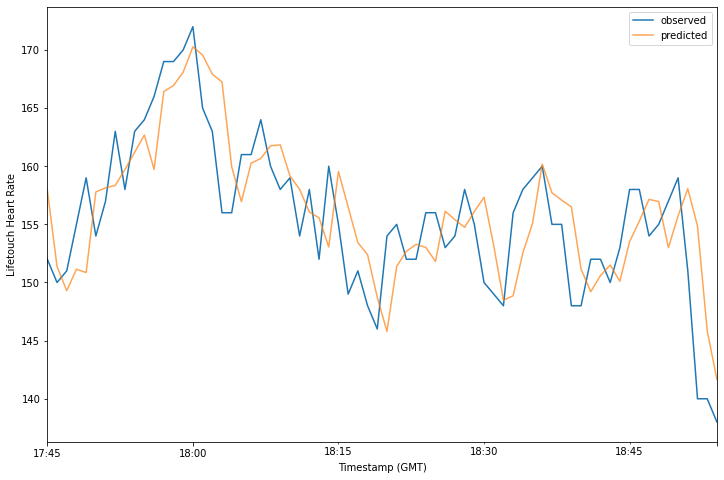

In [ ]:
# plot observations and predictions
ax = Heart2['2015-08-17 17:45:00':]['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# Out-of-sample forecasts
forecasts = model_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    137.488528
2015-08-17 18:56:00    137.368539
2015-08-17 18:57:00    139.192958
2015-08-17 18:58:00    138.561379
2015-08-17 18:59:00    137.752635
2015-08-17 19:00:00    139.097223
2015-08-17 19:01:00    136.870632
2015-08-17 19:02:00    137.849670
2015-08-17 19:03:00    137.282643
2015-08-17 19:04:00    136.613949
2015-08-17 19:05:00    136.910652
2015-08-17 19:06:00    137.549929
2015-08-17 19:07:00    137.007737
2015-08-17 19:08:00    136.234227
2015-08-17 19:09:00    138.580025
2015-08-17 19:10:00    137.841272
2015-08-17 19:11:00    136.878259
2015-08-17 19:12:00    138.391468
2015-08-17 19:13:00    136.104203
2015-08-17 19:14:00    137.053510
Freq: T, Name: predicted_mean, dtype: float64


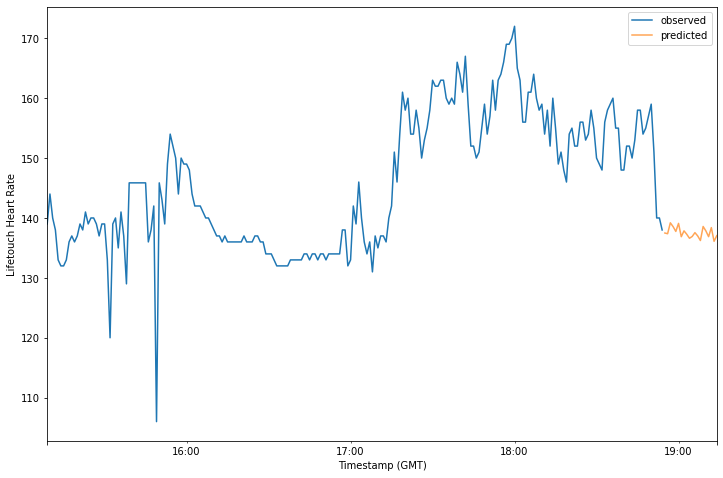

In [ ]:
# plot observations and predictions
ax = Heart2['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
forecasts.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

##MODEL 4 - ARIMA

Data exploration

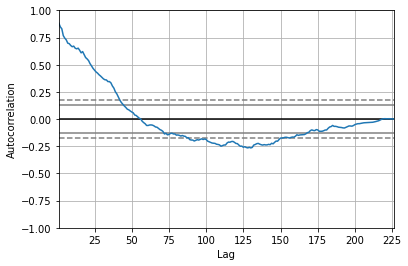

In [ ]:
#Understanding the data using autocorelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Heart2)
plt.show()

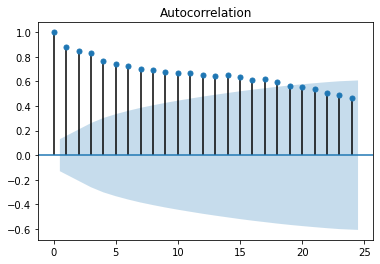

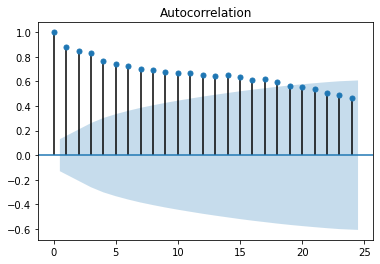

In [ ]:
#To view the ACF for the edited dataset
plot_acf(Heart2)

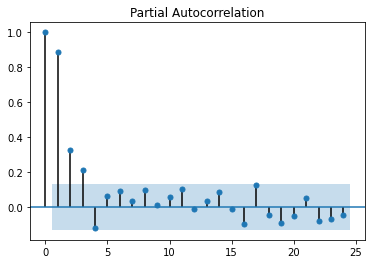

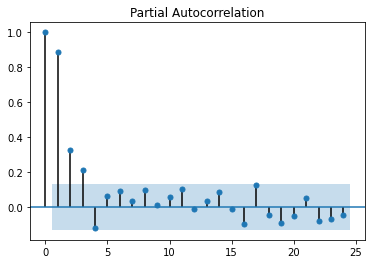

In [ ]:
#To view the PACF for the edited dataset
plot_pacf(Heart2)

## Training and splitting the dataset

In [ ]:
#Dataset splitting into train and test

X = Heart2.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):

  # fit model
  model = ARIMA(Heart2, order=(4,1,0))
  model_fit = model.fit()
  output = model_fit.forecast(steps=20)
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

  
 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=151.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=159.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=154.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=157.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=163.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=163.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=164.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=166.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=169.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=169.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=170.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=172.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=165.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=163.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=156.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=156.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=161.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=161.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=164.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=160.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=159.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=154.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=152.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=160.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=149.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=151.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=148.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=146.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=154.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=152.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=152.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=156.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=156.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=153.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=154.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=150.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=149.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=148.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=156.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=159.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=160.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=148.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=148.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=152.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=152.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=150.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=153.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=158.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=154.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=155.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=157.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=159.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=151.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=140.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=140.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


predicted=139.743324, expected=138.000000


###MODEL EVALUATION

The one with the lowest error is preferable

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

mae = sqrt(mean_absolute_error(test, predictions))
print('Test MAE: %.3f' % mae)


Test RMSE: 17.358
Test MAE: 4.013


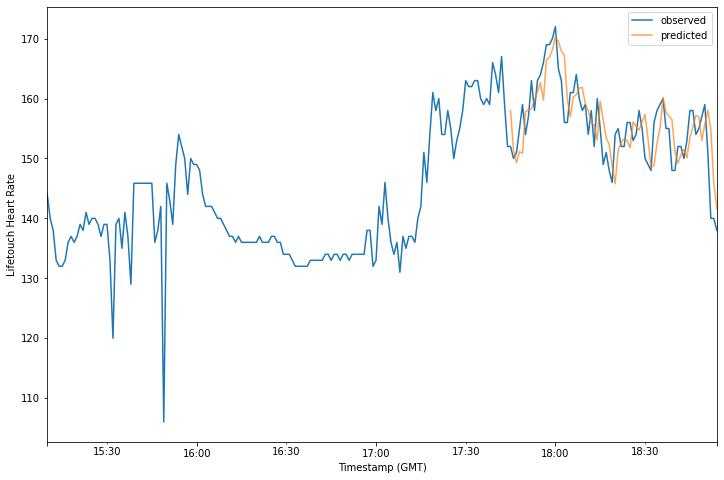

In [ ]:
# plot observations and predictions
ax = Heart2['2015-08-17 15:10:00':]['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# Out-of-sample forecasts
#output = model_fit.forecast(steps=20)
print(output)

2015-08-17 18:55:00    139.743324
2015-08-17 18:56:00    141.643931
2015-08-17 18:57:00    142.108955
2015-08-17 18:58:00    144.020172
2015-08-17 18:59:00    146.007153
2015-08-17 19:00:00    145.197663
2015-08-17 19:01:00    145.885333
2015-08-17 19:02:00    147.131277
2015-08-17 19:03:00    147.483843
2015-08-17 19:04:00    146.946618
2015-08-17 19:05:00    145.862407
2015-08-17 19:06:00    145.316171
2015-08-17 19:07:00    145.798853
2015-08-17 19:08:00    144.694332
2015-08-17 19:09:00    142.772894
2015-08-17 19:10:00    143.001455
2015-08-17 19:11:00    143.112919
2015-08-17 19:12:00    143.025680
2015-08-17 19:13:00    143.092892
2015-08-17 19:14:00    143.417761
Freq: T, Name: predicted_mean, dtype: float64


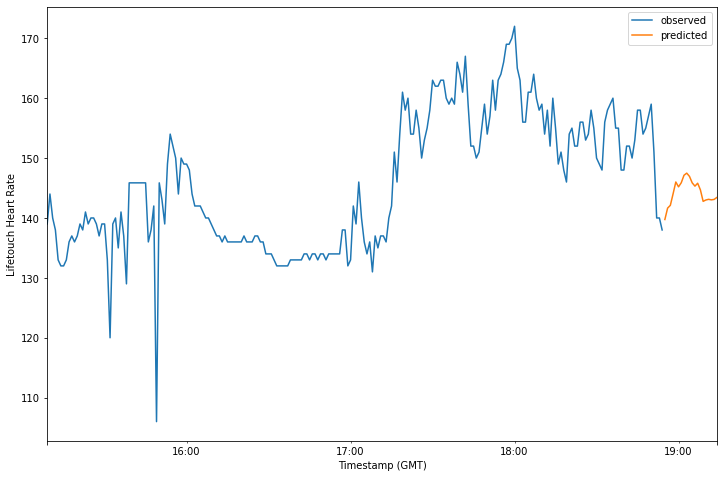

In [ ]:
# plot observations and predictions
ax = Heart2['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
output.plot(ax=ax, label='predicted')

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

This looks like the best model for this task

##MODEL 5 - SMOOTHING 

##Fitting the Data with Holt-Winters Exponential Smoothing

Now we shall fit this data on Single, Double, and Triple Exponential Smoothing respectively, and will see how it performs.

Before starting with the models, we shall first define the weight coefficient Alpha and the Time Period. 

We also set the DateTime frequency to a minute by minute level.

In [ ]:
# Set the frequency of the date time index as Monthly start as indicated by the data
Heart2.index.freq = 'min'
# Set the value of Alpha and define m (Time Period)
m = 60
alpha = 1/(2*m)

Now, we will fit the data on the Single Exponential Smoothing,

Single Exponential Smoothing

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<Figure size 864x576 with 0 Axes>

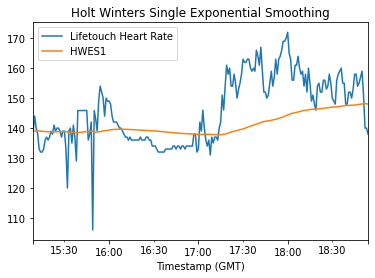

In [ ]:
plt.figure(figsize=(12, 8))
Heart2['HWES1'] = SimpleExpSmoothing(Heart2['Lifetouch Heart Rate']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
Heart2[['Lifetouch Heart Rate','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

Double Exponential Smoothing

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<Figure size 864x576 with 0 Axes>

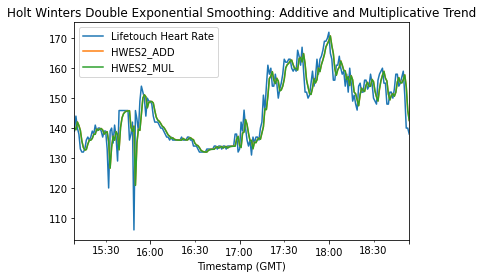

In [ ]:
plt.figure(figsize=(12, 8))
Heart2['HWES2_ADD'] = ExponentialSmoothing(Heart2['Lifetouch Heart Rate'],trend='add').fit().fittedvalues
Heart2['HWES2_MUL'] = ExponentialSmoothing(Heart2['Lifetouch Heart Rate'],trend='mul').fit().fittedvalues
Heart2[['Lifetouch Heart Rate','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

Triple Exponential Smoothing

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<Figure size 864x576 with 0 Axes>

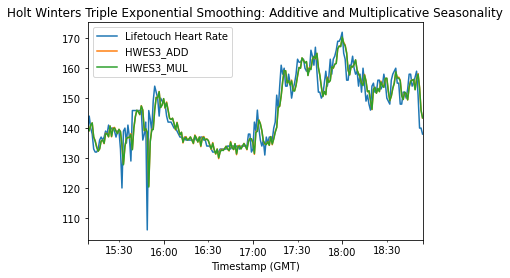

In [ ]:
plt.figure(figsize=(12, 8))
Heart2['HWES3_ADD'] = ExponentialSmoothing(Heart2['Lifetouch Heart Rate'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
Heart2['HWES3_MUL'] = ExponentialSmoothing(Heart2['Lifetouch Heart Rate'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
Heart2[['Lifetouch Heart Rate','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

In [ ]:
# Split into train and test set
train_heartrecord2 = Heart2[:150]
test_heartrecord2 = Heart2[150:]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

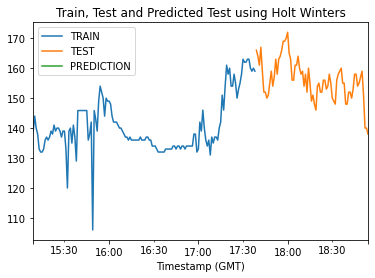

In [ ]:
fitted_model = ExponentialSmoothing(train_heartrecord2['Lifetouch Heart Rate'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast()
train_heartrecord2['Lifetouch Heart Rate'].plot(legend=True,label='TRAIN')
test_heartrecord2['Lifetouch Heart Rate'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

##Forecasting with Holt-Winters Exponential Smoothing (Triple ES)

In [ ]:
# Out-of-sample forecasts
forecast = model_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    139.743324
2015-08-17 18:56:00    141.643931
2015-08-17 18:57:00    142.108955
2015-08-17 18:58:00    144.020172
2015-08-17 18:59:00    146.007153
2015-08-17 19:00:00    145.197663
2015-08-17 19:01:00    145.885333
2015-08-17 19:02:00    147.131277
2015-08-17 19:03:00    147.483843
2015-08-17 19:04:00    146.946618
2015-08-17 19:05:00    145.862407
2015-08-17 19:06:00    145.316171
2015-08-17 19:07:00    145.798853
2015-08-17 19:08:00    144.694332
2015-08-17 19:09:00    142.772894
2015-08-17 19:10:00    143.001455
2015-08-17 19:11:00    143.112919
2015-08-17 19:12:00    143.025680
2015-08-17 19:13:00    143.092892
2015-08-17 19:14:00    143.417761
Freq: T, Name: predicted_mean, dtype: float64


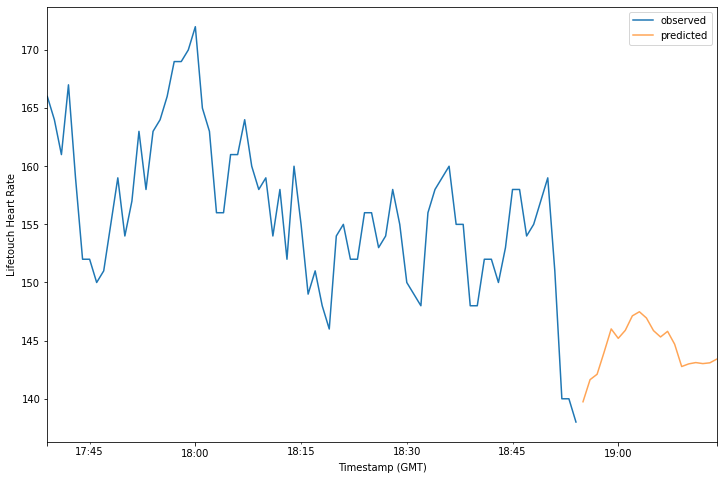

In [ ]:
# plot observations and predictions for the forecast
ax = test_heartrecord2['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
forecasts.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

XGBoost Optimiser

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
# split data into X and y
X = Heart2[:126]
Y = Heart2[126:]

In [ ]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = TimeSeriesSplit()


TypeError: ignored

USING SVR MODEL

In [ ]:
tss = TimeSeriesSplit()
tss

In [ ]:
#Defining the model
model = SVC(kernel='rbf', C=1, gamma=1) # Linear Kernel

In [ ]:
# #Splitting and training the data for test and train purpose
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.3, random_state=1)


In [ ]:
#Splitting train and test sets for both features and targets
for train_index, test_index in tss.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:

# import json

# predictions = [139.74332448, 141.64393143, 142.10895489, 144.02017245, 146.00715285, 145.19766286, 145.88533322, 147.1312774, 147.48384294, 146.94661761, 145.86240712, 145.31617088, 145.79885273, 144.69433205, 142.77289372, 143.00145542, 143.11291932, 143.02568001, 143.09289154, 143.41776138]


# data = []
# for pred in predictions:
#     data.append({'prediction': pred})

# print(data[0:20])

# submission_file_path = "submission.json"
# with open(submission_file_path, 'w') as fp:
#     fp.write('\n'.join(json.dumps(i) for i in data))